In [11]:
import json
import os
import numpy as np
import datetime
import skimage
from osgeo import gdal, osr

In [19]:
class Dataset(object):
    def __init__(self):
        now = datetime.datetime.now()
        self.info_info = [{'year':now.year,'version':'','description':'','contributor':'','url':'','date_created':str(now)}]
        # Background is always the first class
        #list of dictionaries
        self.license_info = [{'id': 0, 'name': 'GEOJsonToCOCO', 'url': ''}]
        #self.categories_info = [{'id': 0, 'name': 'BG', 'supercategory': ''}]
        self.categories_info = []
        #list of dictionaries
        self.images_info = []
        self.annotations_info = []
        
    def load_geojson_file(self, filePath, imagePath):
        print(imagePath)
        json_file = open(filePath)
        geo_json = json.load(json_file)
        json_file.close()
        
        
        imageFilename = os.path.split(imagePath)[1]
        #split out the digits at the end of the filename
        imageID = int(imageFilename.split('.')[0].split('_')[-1][3:])
        
        src_raster = gdal.Open(imagePath)
        geom_transform = src_raster.GetGeoTransform()
        longCorner = geom_transform[0]
        latCorner = geom_transform[3]
        pixelWidth = geom_transform[1]
        pixelHeight = geom_transform[5]
        
        for feature in geo_json['features']:
            paved_id = feature['properties']['paved']
            bridge_id = feature['properties']['bridge_type']
            cat_id, cat_name = self.convert_cat(paved_id, bridge_id)
            self.add_category(cat_id, cat_name)
        
        #Check to ensure there are annotations in the file
        if geo_json['features'] != []:
            #Add lines
            for feature in geo_json['features']:
                if feature['geometry']['type'] == 'LineString':

                    coordinatesSet = feature['geometry']['coordinates']
                    #print(coordinatesSet)
                    
                    pixelCoordinates = self.convert_coordinatesSet(coordinatesSet, longCorner, latCorner, pixelWidth, pixelHeight)                                    
                    print(pixelCoordinates)   
                    objectID = feature['properties']['road_id']
                        
                    paved_id = feature['properties']['paved']
                    bridge_id = feature['properties']['bridge_type']
                    cat_id, cat_name = self.convert_cat(paved_id, bridge_id)
                        
                    self.add_annotation(objectID, imageID, cat_id, pixelCoordinates)
                    
                elif feature['geometry']['type'] == 'MultiLineString':
                    for coordinatesSet in feature['geometry']['coordinates']:
                    

                        pixelCoordinates = self.convert_coordinatesSet(coordinatesSet, longCorner, latCorner, pixelWidth, pixelHeight)                                    
                        
                        objectID = feature['properties']['road_id']
                        
                        paved_id = feature['properties']['paved']
                        bridge_id = feature['properties']['bridge_type']
                        cat_id, cat_name = self.convert_cat(paved_id, bridge_id)
                        
                        self.add_annotation(objectID, imageID, cat_id, pixelCoordinates)
                else:
                    print(feature['geometry']['type'])
            
        #Check to make an annotation exists for this image (met the criteria above) before adding the image to the list
        if next((item for item in self.annotations_info if item["image_id"] == imageID), False):
                image = skimage.io.imread(imagePath)
                imageWidth = image.shape[0]
                imageHeight = image.shape[1]
                #Add image to the image_info list
                self.add_image(imageFilename, imageID, imageWidth, imageHeight) 
        
        
    def convert_cat(self, paved_id, bridge_id):
#Changed because, contrary to what we found on the web, it seems
#paved_id = 1 for unpaved and paved_id=2 for paved.
        cat_id = 0
        cat_name = 'BG'
        if paved_id == '1':
                cat_id = 1
                cat_name = "Unpaved"
        elif paved_id == '2':
                cat_id = 2
                cat_name = "Paved"
        elif paved_id == '3':
                cat_id = 3
                cat_name = "Unknown"
        elif bridge_id == '2':
                cat_id = 4
                cat_name = "Bridge"
        return cat_id, cat_name
    
    def convert_coordinatesSet(self, coordinatesSet, longCorner, latCorner, pixelWidth, pixelHeight):
        pixelCoordinates = []
        for coordinates in coordinatesSet:
            xcoord = coordinates[0]
            ycoord = coordinates[1]
            xPixel = (xcoord - longCorner) / pixelWidth
            yPixel = (ycoord - latCorner) / pixelHeight
            pixelCoordinates.append(xPixel)
            pixelCoordinates.append(yPixel)
        return pixelCoordinates
    
    def convert_coordinates(self, xcoord, ycoord, longCorner, latCorner, pixelWidth, pixelHeight):
        xPixel = (xcoord - longCorner) / pixelWidth
        yPixel = (latCorner - ycoord) / pixelHeight
        return xPixel, yPixel
    
    def add_annotation(self, objectID, imageID, category_id, roadCoordsList):
        self.annotations_info.append({'id' : objectID, 
                                       'image_id' : imageID, 
                                       'category_id' : category_id, 
                                       'segmentation' : [roadCoordsList], 
                                       'area' : 0, 
                                       'bbox' : [], 
                                       'iscrowd' : 0})
                    
    def add_image(self, imageFilename, imageID, imageWidth, imageHeight):
        self.images_info.append({'id':imageID,
                                 'width':imageWidth,
                                 'height':imageHeight,
                                 'file_name': imageFilename,
                                 'license':'',
                                 'flicker_url':'',
                                 'coco_url':'',
                                 'date_captured':''})
        
    def load_data(self, annotation_dir, images_dir):
        
        for jsonFile in os.listdir(annotation_dir):
            if jsonFile.split('.')[-1] == 'geojson':
                jsonFilenameRoot = jsonFile.split('geojson_roads')
                #Pull the folder name for the image_dir (PAN, MIL, etc)
                imageType = image_dir.split('/')[-2]
                #Assemble image name that corresponds with the annotation file
                image = jsonFilenameRoot[0] + imageType + jsonFilenameRoot[1].split('.')[0]+'.tif'
                
                imagePath = os.path.join(image_dir, image)
                    
                filePath = os.path.join(annotation_dir, jsonFile)
                    
                #Execute for every geojson file in the folder
                self.load_geojson_file(filePath, imagePath)
                
    def add_category(self, cat_id, cat_name):
        
        if next((item for item in self.categories_info if item["id"] == cat_id), False):

            # cat_id combination already available, skip
            return
        self.categories_info.append({
            "id": cat_id,
            "name": cat_name,
            "supercategory": ''
        }) 

    
    def write_json(self, outputName):
        json_dict = {'license': self.license_info, 'info': self.info_info, 'categories': self.categories_info,
                     'images': self.images_info, 'annotations': self.annotations_info}
        with open(outputName, 'w', encoding='utf-8') as f:
            json.dump(json_dict, f, ensure_ascii=False, indent=4)
        

In [21]:
dataset = Dataset()
annotation_dir = '/mnt/shared/bryan/RoadsTest/JSON/'
image_dir = '/mnt/shared/bryan/RoadsTest/PAN/'
dataset.load_data(annotation_dir, image_dir)
dataset.write_json('/mnt/shared/bryan/RoadsTest/test.json')

/mnt/shared/bryan/RoadsTest/PAN/SN3_roads_train_AOI_5_Khartoum_PAN_img1.tif
[619.5897849501481, -0.0, 592.651106614399, 107.32442106718857]
[1173.906923275397, -0.0, 1173.908513917418, 0.1866433085119062]
[878.535180637322, 397.08516175644394, 857.2729584175701, 264.88738400247973]
[857.2729584175701, 264.88738400247973, 740.4685139954555, 283.1196062214148, 668.8529584535836, 291.03886547923065, 618.5844399440704, 287.93997659107424, 550.8125881021884, 274.009235852833]
[1175.4559213262648, 181.67701364706932, 1165.362587993829, 342.89923584044135]
[1024.7574028343886, 386.182198795956, 983.4603658036276, 96.52849514336422, 951.6755509948986, 98.13590255058563]
[592.651106614399, 107.32442106718857, 550.8125881021884, 274.009235852833]
[857.2729584175701, 264.88738400247973, 858.2211065676822, 239.04849511781345, 848.6144399026191, 106.61330995657814]
[1300.0, 175.9974233941721, 1175.4559213262648, 181.67701364706932]
[592.651106614399, 107.32442106718857, 697.0862917810393, 108.90108

In [33]:
import geopandas as gpd
import osmnx as ox
def create_buffer_geopandas(geoJsonFileName, 
                            bufferDistanceMeters=2, 
                            bufferRoundness=1, projectToUTM=True):
    '''
    Create a buffer around the lines of the geojson. 
    Return a geodataframe.
    '''
    
    inGDF = gpd.read_file(geoJsonFileName)

    # set a few columns that we will need later
    inGDF['type'] = inGDF['road_type'].values            
    #inGDF['class'] = 'highway'  
    #inGDF['highway'] = 'highway'  
    
    if len(inGDF) == 0:
        return [], []
    # Transform gdf Roadlines into UTM so that Buffer makes sense
    if projectToUTM:
        tmpGDF = ox.project_gdf(inGDF)
    else:
        tmpGDF = inGDF
    gdf_utm_buffer = tmpGDF
    print(gdf_utm_buffer.crs)
    # perform Buffer to produce polygons from Line Segments
    gdf_utm_buffer['geometry'] = tmpGDF.buffer(bufferDistanceMeters,bufferRoundness)
    #gdf_utm_dissolve = gdf_utm_buffer.dissolve(by='road_type')
    gdf_utm_buffer.crs = gdf_utm_buffer.crs

    if projectToUTM:
        gdf_buffer = gdf_utm_buffer.to_crs(inGDF.crs)
    else:
        gdf_buffer = gdf_utm_buffer
    return gdf_buffer

In [41]:
test = create_buffer_geopandas('/mnt/shared/bryan/RoadsTest/JSON/SN3_roads_train_AOI_5_Khartoum_geojson_roads_img1.geojson', projectToUTM=False)

{'init': 'epsg:4326'}


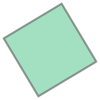

In [48]:
test.loc[6]['geometry']